# Audio Signal Modeling with SIREN using Alpine

---


This example demonstrates how to use the **Alpine** library to implement the SIREN architecture for modeling audio waveforms. Alpine is a flexible, user-friendly, and distributed PyTorch library for Implicit Neural Representations. Alpine provides a systematic way to build, train, and visualize neural fields or neural representations across a wide variety of scientific and medical data. 

We first use Alpine to load an audio file and preprocess it. Then, we define the SIREN model architecture, train it on the audio data, and finally evaluate its performance.
This notebook demonstrates basic usage of Alpine for audio signal modeling.

## Tip: Use GPU Acceleration
If you are running this notebook in Google Colab, navigate to `Runtime > Change runtime type` and select `GPU` as the hardware accelerator. This will significantly speed up the training process.

## Steps in this example:
In this example we will:
- Load and preprocess an audio file using Alpine.
- Define the SIREN model architecture.
- Train the SIREN model on the audio data.
- Evaluate the model's performance and visualize the results.

## Install Alpine
Alpine can be installed from the source repository. We run the following to install Alpine and its dependencies.


In [ ]:
!git clone https://github.com/kushalvyas/alpine.git
%cd alpine
!pip3 install -e .


---

## Preparing the dataset

For this example, we will use a sample audio file `examples/data/moonlight.mp3`.  
You can replace this with any audio file of your choice.

Alpine provides flexible dataloaders to handle signals of different types and dimensionalities.  
When working with audio, the goal is to represent the waveform as a continuous signal that the model can learn to approximate.

### Choosing the Right DataLoader

Audio signals can be thought of as a sequence of samples along a single dimension (time). Alpine provides data loaders that can handle 1D signals effectively. For audio waveform modeling, we will use the `NDSignalLoader`, which is designed to handle N-dimensional signals, including 1D audio waveforms.
`NDSignalLoader` takes the raw waveform, normalizes it, and prepares the `(coordinates, signal)` pairs required for SIREN training.  


In [11]:
import torch
import torchaudio
import torch.nn as nn

from pathlib import Path
from matplotlib import pyplot as plt
from tqdm import tqdm

from alpine.models import Siren
from alpine.dataloaders import NDSignalLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load the audio file with torchaudio
try:
    waveform, sample_rate = torchaudio.load("alpine/examples/data/moonlight.mp3")
except FileNotFoundError:
    print(f"Error: Audio file not found")
    exit()

# Convert to mono
mono_waveform = waveform[0]

# NDSignalLoader normalizes to [0, 1] by default, we will provide our own normalization function to normalize to [-1, 1]
def normalize_audio(signal):
    return signal / signal.abs().max()

# Create the dataset using the audio waveform and the custom normalization function
dataset = NDSignalLoader(mono_waveform, (mono_waveform.shape[0],), normalize_signal=False, normalize_fn=normalize_audio)

# Create the DataLoader for the dataset with batch size 1
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True if device.type == 'cuda' else False
)

Using device: mps



---

## Defining the model

Alpine provides a flexible way to define the SIREN architecture. In this example, we will use the `Siren` class from Alpine to create our model. The SIREN architecture uses sine activation functions, which are particularly effective for modeling continuous signals like audio waveforms. 

The INR maps coordinates (time points) to signal values (amplitude), so the input dimension is 1 (time) and the output dimension is also 1 (amplitude). We set the outermost layer to linear to ensure that the output is not constrained by a non-linear activation function.

We also set the ```omega``` hyperparmaeters that control the frequency of the sine activations. A higher omega value allows the model to capture higher frequency details in the audio signal.

In [23]:
# Define the Siren model with specified parameters
model = Siren(
    in_features=1,
    hidden_features=256,
    hidden_layers=3,
    out_features=1,
    outermost_linear=True,
    omegas=[3000.0, 30.0, 30.0],
    bias=True
).to(device)

# Optimize with torch.compile if on a CUDA GPU
if device.type == 'cuda':
    print("Compiling model for CUDA backend...")
    model = torch.compile(model)

print(model)

Siren(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (model): ModuleList(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Sine()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Sine()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)



---

## Training the model

Now we fit the Siren model to the audio data. Since we are working with audio signals, we will use the Mean Squared Error (MSE) loss function, which is suitable for regression tasks like this. Note that Alpine also provides a set of metric functions that can be used to evaluate the model's performance.

In [26]:
EPOCHS = 1000
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
loss_function = nn.MSELoss()

loss_history = []

for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    model.train()
    for batch in dataloader:
        coords = batch['input'].to(device)
        signal = batch['signal'].to(device)

        optimizer.zero_grad()
        prediction = model(coords)['output']
        loss = loss_function(prediction, signal)
        loss.backward()
        optimizer.step()

    loss_history.append(loss.item())
    # Update the learning rate
    scheduler.step()

Training Progress: 100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]



---

## Evaluating the model

Now that the model is trained, we can evaluate its performance by comparing the original audio signal with the reconstructed signal from the SIREN model. We will visualize both signals to see how well the model has learned to approximate the audio waveform.

To evaluate the performance, we will plot the original and reconstructed audio signals. We will also compute the Mean Squared Error (MSE) between the two signals to quantify the reconstruction quality. 
We also plot spectrograms of the original signal and the reconstructed signal to visualize how well the model has captured the frequency content of the audio.

Finally, we can listen to the original and reconstructed audio signals to hear how well the model has captured the nuances of the waveform.

First, we plot the loss curve to visualize training progress.

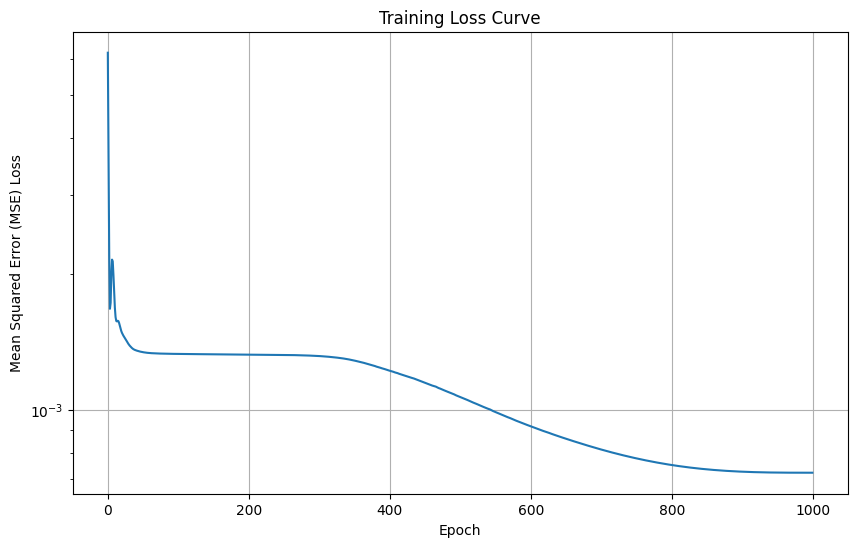

In [27]:
# Create the of the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE) Loss")
plt.yscale('log')  # Use a logarithmic scale
plt.grid(True)
plt.show()

We set the model to evaluation mode and generate the reconstructed audio by passing the entire range of coordinates through the trained model. The output is then reshaped to match the original waveform's shape.

In [28]:
model.eval() # Set the model to evaluation mode
# Reconstruct the entire signal
with torch.no_grad():
    all_coords = dataset.grid_tensor.to(device)
    preds = []
    # Process in chunks to avoid OOM errors on very large signals
    for chunk in torch.split(all_coords, 65536):
        preds.append(model(chunk)['output'])
    reconstructed = torch.cat(preds, dim=0).squeeze(-1).cpu()


We use the reconstructed waveform to compare the original and reconstructed audio signals.

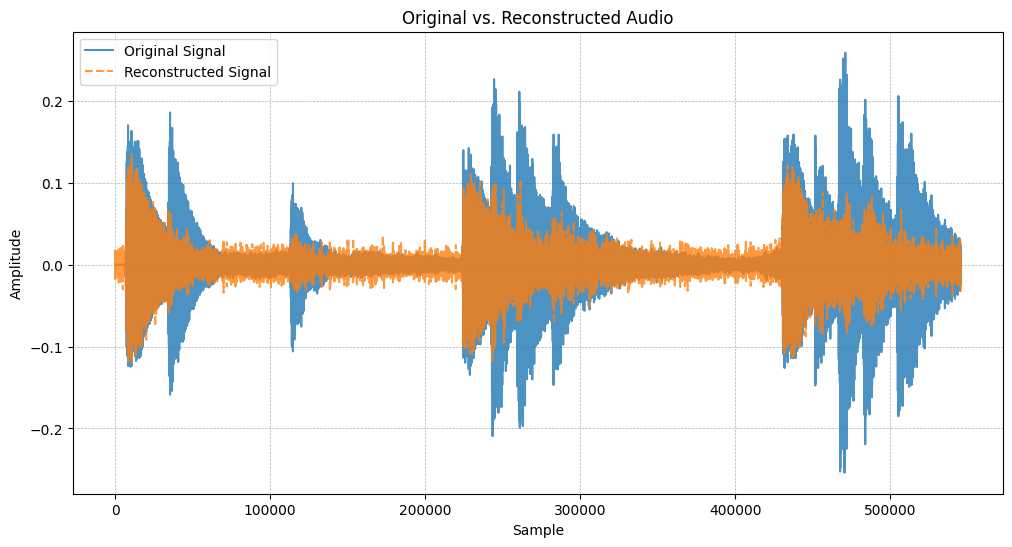

In [29]:

plt.figure(figsize=(12, 6))
plt.plot(dataset.signal.cpu().numpy(), label="Original Signal", alpha=0.8)
plt.plot(reconstructed.numpy(), label="Reconstructed Signal", linestyle='--', alpha=0.8)
plt.title("Original vs. Reconstructed Audio")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

We can also plot the spectrograms of the original and reconstructed audio signals to visually compare their frequency content.

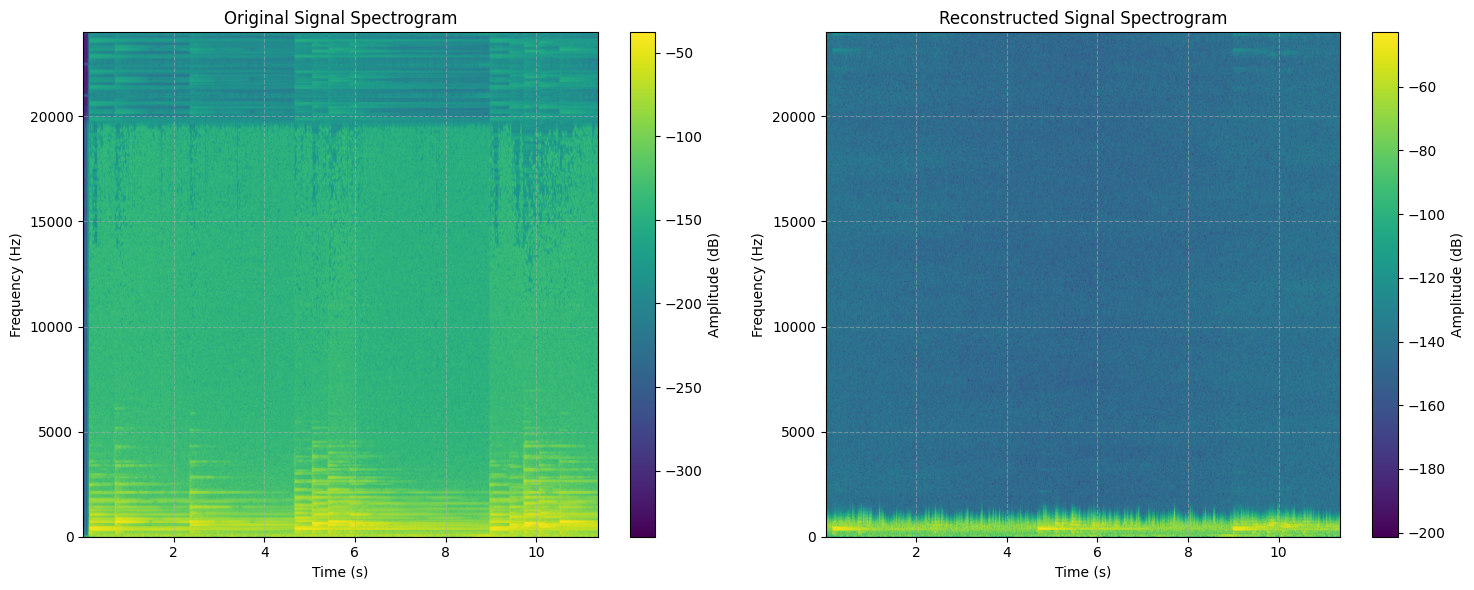

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

# Original Signal Spectrogram
original_spec = ax1.specgram(dataset.signal.cpu().numpy().flatten(), NFFT=1024, Fs=sample_rate, noverlap=512, cmap='viridis')
ax1.set_title("Original Signal Spectrogram")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Frequency (Hz)")
ax1.grid(True, linestyle='--', alpha=0.5)
cbar1 = plt.colorbar(original_spec[3], ax=ax1, orientation='vertical')
cbar1.set_label("Amplitude (dB)")

# Reconstructed Signal Spectrogram
reconstructed_spec = ax2.specgram(reconstructed.numpy().flatten(), NFFT=1024, Fs=sample_rate, noverlap=512, cmap='viridis')
ax2.set_title("Reconstructed Signal Spectrogram")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Frequency (Hz)")
ax2.grid(True, linestyle='--', alpha=0.5)
cbar2 = plt.colorbar(reconstructed_spec[3], ax=ax2, orientation='vertical')
cbar2.set_label("Amplitude (dB)")

plt.tight_layout()
plt.show()

Finally, we save the reconstructed audio to a file and play both the original and reconstructed audio signals so we can hear the differences.

In [31]:
output_dir = Path("audio_results")
output_dir.mkdir(parents=True, exist_ok=True)

# 2. Save the reconstructed audio file
waveform_out = reconstructed.clamp(-1, 1).unsqueeze(0).float()
torchaudio.save(output_dir / "reconstructed.wav", waveform_out, sample_rate)

print("Reconstructed audio saved to 'audio_results/reconstructed.wav'")



Reconstructed audio saved to 'audio_results/reconstructed.wav'


/Users/danielkim/Documents/Documents_MacBook_Pro/School/Rice/Research/alpine-1/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
